# ARAD (Autoencoder Reconstruction Anomaly Detection)

This notebook demonstrates the ARAD algorithm for identifying radioactive sources in gamma-ray time series data using a trained autoencoder.

## Algorithm Overview

The ARAD detector:
1. **Learns background patterns** using a convolutional autoencoder on source-absent training data
2. **Computes reconstruction error** using Chi Squared between input and reconstruction
3. **Detects anomalies** when reconstruction error exceeds threshold
4. **Aggregates alarms** that are close in time

## Key Features
- **Deep learning**: Uses convolutional autoencoder to capture complex spectral patterns
- **Chi2 metric**: More robust than MSE for spectral comparison
- **Unsupervised**: Only needs background data for training
- **Interpretable**: Reconstruction error + saliency maps show what's anomalous

## Dataset

Using the TopCoder Urban Data Challenge dataset (mobile NaI detector).


## Setup


In [1]:
# Imports
import sys
sys.path.insert(0, '../../gammaflow')
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

# GammaFlow imports
from gammaflow import Spectrum, SpectralTimeSeries, ListMode
from gammaflow.core.spectra import Spectra
from gammaflow.visualization import plot_count_rate_time_series

# Detection algorithm
from src.detectors import ARADDetector

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

%matplotlib inline

print("✅ ARAD Detection - Ready!")


/Users/jghawaly/CODE/gammaflow/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ ARAD Detection - Ready!


## Load Data Helper


In [2]:
def load_listmode_run(run_id, data_dir='../topcoder', dataset='training'):
    """Load a run and return ListMode object + metadata."""
    data_path = Path(data_dir)
    
    # Load listmode data
    run_file = data_path / dataset / f"{run_id}.csv"
    data = pd.read_csv(run_file, header=None, names=['time_delta_us', 'energy_keV'])
    
    # Convert to seconds
    time_deltas = data['time_delta_us'].values * 1e-6
    energies = data['energy_keV'].values
    
    # Load metadata
    answer_key_file = data_path / 'scorer' / f'answerKey_{dataset}.csv'
    answer_key = pd.read_csv(answer_key_file)
    metadata = answer_key[answer_key['RunID'] == run_id].iloc[0].to_dict()
    
    # Map SourceID to source name
    source_map = {
        0: 'Background',
        1: 'HEU',
        2: 'WGPu',
        3: 'I-131',
        4: 'Co-60',
        5: 'Tc-99m',
        6: 'Tc-99m + HEU'
    }
    metadata['SourceName'] = source_map.get(metadata['SourceID'], f"Unknown({metadata['SourceID']})")
    
    # Create ListMode
    listmode = ListMode(time_deltas, energies)
    
    return listmode, metadata

print("✅ Load function ready")


✅ Load function ready


## Load Trained ARAD Model

We'll load the ARAD model that was trained on background data using the `train_arad.py` script.


In [3]:
# Load the trained ARAD detector
model_path = '../models/arad_background.pt'

print(f"Loading trained ARAD model from {model_path}...")

detector = ARADDetector(
    latent_dim=8,
    dropout=0.2,
    aggregation_gap=2.0,  # Merge alarms < 2 seconds apart
    verbose=True,
    loss_type='chi2'
)

detector.load(model_path)

print(f"\n✅ Model loaded successfully!")
print(f"   Model config:")
print(f"     - Latent dimension: {detector.latent_dim}")
print(f"     - Number of bins: {detector.n_bins_}")
print(f"     - Device: {detector.device}")
print(f"     - Current threshold: {detector.threshold if detector.threshold is not None else 'Not set'}")


Loading trained ARAD model from ../models/arad_background.pt...
ARAD using device: mps
Model loaded from ../models/arad_background.pt

✅ Model loaded successfully!
   Model config:
     - Latent dimension: 8
     - Number of bins: 128
     - Device: mps
     - Current threshold: Not set


## Set Threshold Based on False Alarm Rate

We'll calibrate the threshold using the **alarms per hour** metric, which is the standard for operational radiation detection systems. ANSI N42.48 typically requires **< 1 alarm/hour** for nuisance alarm rates.


In [4]:
# Load background time series for threshold calibration
# NOTE: Using just the first background run (same approach as SAD detector)
# This is faster and provides a fair comparison between algorithms.
#
# ⚠️  FOR REAL-WORLD/PRODUCTION USE: You should calibrate on MULTIPLE background
#     runs (e.g., 20+) to get robust statistics and account for environmental
#     variations, detector drift, and different background conditions. Using a
#     single run is acceptable for testing and algorithm comparison, but not
#     for operational deployment.
print("Loading background time series for threshold calibration...")

data_path = Path('../topcoder')
answer_key = pd.read_csv(data_path / 'scorer' / 'answerKey_training.csv')
background_run_ids = answer_key[answer_key['SourceID'] == 0]['RunID'].values

# Load just the first background run (matches SAD's approach)
print(f"Using first background run (ID: {background_run_ids[0]}) for calibration...")
listmode, _ = load_listmode_run(background_run_ids[0])
calibration_data = SpectralTimeSeries.from_list_mode(
    listmode,
    integration_time=3.0,  # 1-second integration
    stride_time=1.0,
    energy_bins=128,
    energy_range=(20, 2900)
)

print(f"\nCalibration dataset: {calibration_data.n_spectra} spectra")
total_time_hours = np.sum(calibration_data.real_times) / 3600.0
print(f"  Total observation time: {total_time_hours:.2f} hours")

# Set threshold
alarms_per_hour = 0.5  # Conservative target (ANSI compliant)

print(f"\nSetting threshold for {alarms_per_hour} alarms per hour...")
threshold = detector.set_threshold_by_far(calibration_data, alarms_per_hour=alarms_per_hour, max_iterations=100)

print(f"\n✅ Threshold set: {threshold:.4f}")


Loading background time series for threshold calibration...
Using first background run (ID: 100001) for calibration...

Calibration dataset: 64 spectra
  Total observation time: 0.05 hours

Setting threshold for 0.5 alarms per hour...

Calibrating threshold for 0.50 alarms/hour...
  Background data: 64 spectra over 0.05 hours
  Score range: [25.8853, 56.8610]
  Score mean ± std: 38.8515 ± 6.6583
  Starting binary search...
    Iter 1: threshold=55.588387 → 1 alarms (18.75/hr)
    Iter 2: threshold=70.439941 → 0 alarms (0.00/hr)
    Iter 3: threshold=63.014164 → 0 alarms (0.00/hr)
    Iter 4: threshold=59.301276 → 0 alarms (0.00/hr)
    Iter 5: threshold=57.444832 → 0 alarms (0.00/hr)
    Iter 6: threshold=56.516610 → 1 alarms (18.75/hr)
    Iter 7: threshold=56.980721 → 0 alarms (0.00/hr)
    Iter 8: threshold=56.748665 → 1 alarms (18.75/hr)
    Iter 9: threshold=56.864693 → 0 alarms (0.00/hr)
    Iter 10: threshold=56.806679 → 1 alarms (18.75/hr)
    Iter 11: threshold=56.835686 → 1 a

## Test on Run with Source

Now let's test the detector on a run with a radioactive source.


In [5]:
# Load I-131 run with strongest source
i131_runs = answer_key[answer_key['SourceID'] == 3].copy()
i131_runs = i131_runs.sort_values('Speed/Offset', ascending=False)

# Pick the strongest run
test_run_id = i131_runs.iloc[0]['RunID']
speed_offset = i131_runs.iloc[0]['Speed/Offset']

print(f"Loading I-131 test run {test_run_id}...")
print(f"  Speed/Offset: {speed_offset:.2f} (stronger is better)")
listmode, metadata = load_listmode_run(int(test_run_id))

print(f"\nRun Metadata:")
print(f"  Source: {metadata['SourceName']}")
print(f"  Source Time: {metadata['SourceTime']:.1f} seconds")
print(f"  Speed/Offset: {metadata['Speed/Offset']:.2f}")
print(f"\n{listmode}")

# Convert to time series with 1-second integration
print("\nConverting to SpectralTimeSeries...")
test_time_series = SpectralTimeSeries.from_list_mode(
    listmode,
    integration_time=3.0,
    stride_time=1.0,
    energy_bins=128,
    energy_range=(20, 2900)
)

print(f"\nCreated: {test_time_series}")
print(f"  Number of spectra: {test_time_series.n_spectra}")
print(f"  Time coverage: {test_time_series.timestamps[0]:.1f} to {test_time_series.timestamps[-1]:.1f} s")


Loading I-131 test run 107172.0...
  Speed/Offset: 2.17 (stronger is better)

Run Metadata:
  Source: I-131
  Source Time: 34.2 seconds
  Speed/Offset: 2.17

ListMode(n_events=51353, duration=51.83s, rate=990.8Hz)

Converting to SpectralTimeSeries...

Created: SpectralTimeSeries(n_spectra=52, n_bins=128, calibrated, calibration_mode=shared)
  Number of spectra: 52
  Time coverage: 1.5 to 52.5 s


## Run ARAD Detection


In [6]:
print(f"Running ARAD Detection")
print(f"{'='*70}")
print(f"  Latent dimension: {detector.latent_dim}")
print(f"  Threshold: {detector.threshold:.4f}")
print(f"  Device: {detector.device}")
print()

# Process time series
arad_scores, alarms = detector.detect(test_time_series)

print(f"\n{'='*70}")
print(f"Detection Results")
print(f"{'='*70}")
print(f"Number of alarms: {len(alarms)}")

if len(alarms) > 0:
    total_alarm_time = sum(alarm['end_time'] - alarm['start_time'] for alarm in alarms)
    mean_duration = total_alarm_time / len(alarms)
    max_score = max(alarm['peak_score'] for alarm in alarms)
    
    print(f"Total alarm time: {total_alarm_time:.2f} seconds")
    print(f"Mean alarm duration: {mean_duration:.2f} seconds")
    print(f"Peak ARAD score: {max_score:.4f}")
    
    print(f"\nAlarm Events:")
    true_source_time = metadata['SourceTime']
    for i, alarm in enumerate(alarms, 1):
        duration = alarm['end_time'] - alarm['start_time']
        print(f"  {i}. Alarm: t=[{alarm['start_time']:.1f}, {alarm['end_time']:.1f}]s, "
              f"peak={alarm['peak_score']:.4f} at t={alarm['peak_time']:.1f}s, duration={duration:.1f}s")
        
        # Compare to ground truth
        if alarm['start_time'] <= true_source_time <= alarm['end_time']:
            print(f"      ✅ Captured true source (t={true_source_time:.1f}s)")
        else:
            time_diff = min(abs(alarm['start_time'] - true_source_time),
                          abs(alarm['end_time'] - true_source_time))
            print(f"      ⚠️  Offset from true source: {time_diff:.1f}s")
else:
    print("No alarms detected!")


Running ARAD Detection
  Latent dimension: 8
  Threshold: 56.8610
  Device: mps


Detection Results
Number of alarms: 1
Total alarm time: 3.00 seconds
Mean alarm duration: 3.00 seconds
Peak ARAD score: 844.6047

Alarm Events:
  1. Alarm: t=[33.5, 36.5]s, peak=844.6047 at t=35.5s, duration=3.0s
      ✅ Captured true source (t=34.2s)


# Visualize Results

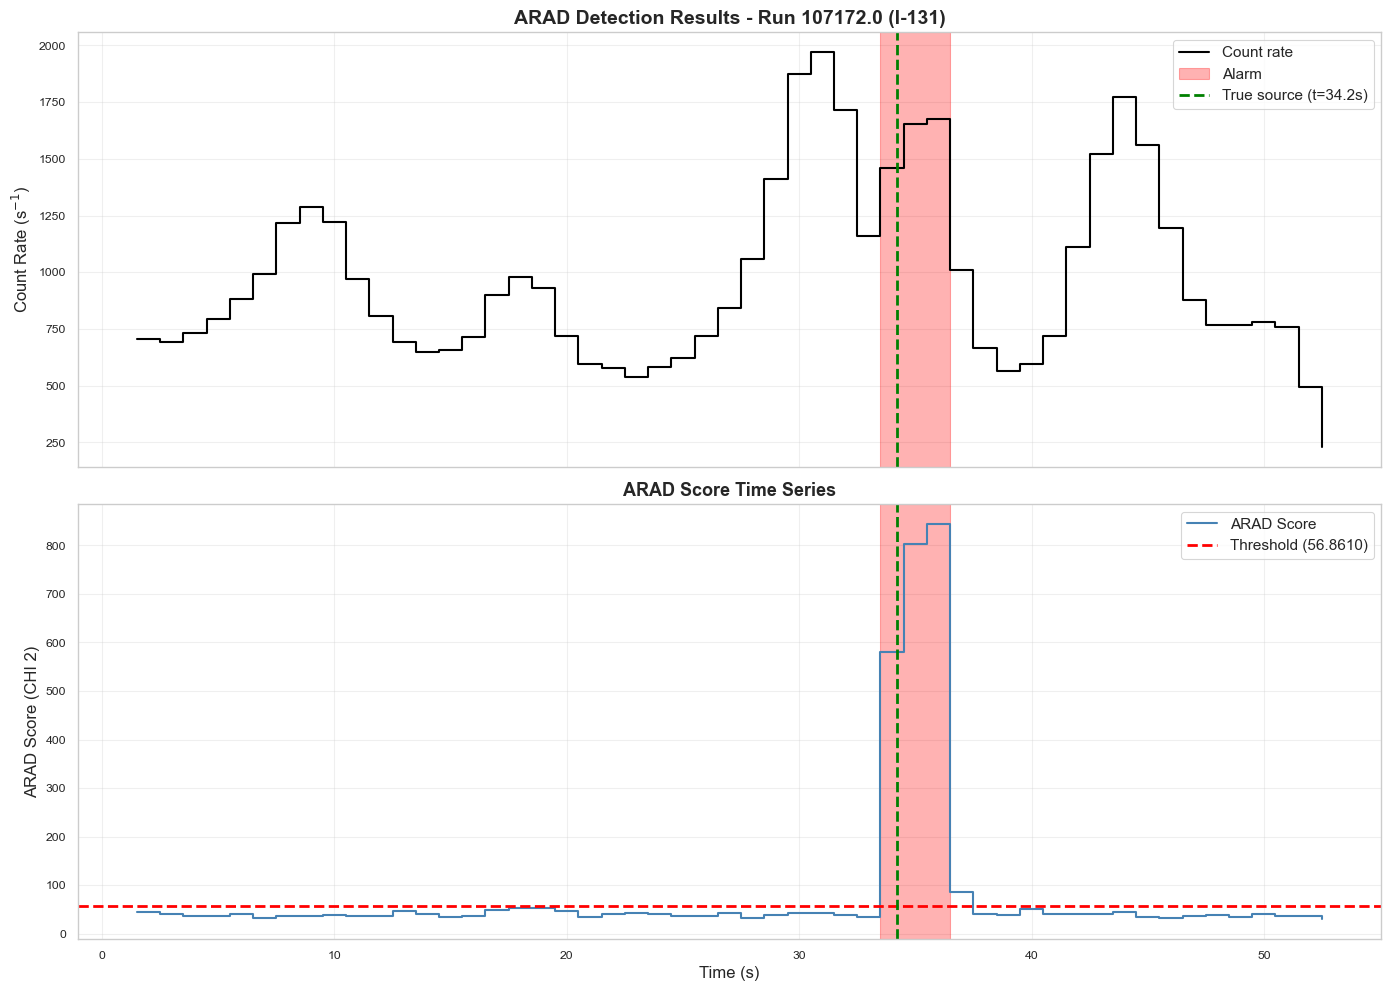


✅ Detection visualization complete!


In [7]:
# Plot ARAD scores with alarm overlay
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Get times and count rates
times = test_time_series.timestamps
count_rates = np.array([
    float(test_time_series[i].counts.sum()) / float(
        test_time_series[i].live_time 
        if (test_time_series[i].live_time is not None and not np.isnan(test_time_series[i].live_time))
        else test_time_series[i].real_time
    )
    for i in range(test_time_series.n_spectra)
])

# Plot 1: Count rate
ax1.step(times, count_rates, where='post', color='black', linewidth=1.5, label='Count rate')
ax1.set_ylabel(r'Count Rate (s$^{-1}$)', fontsize=12)
ax1.set_title(f'ARAD Detection Results - Run {test_run_id} ({metadata["SourceName"]})', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Highlight alarms
for alarm in alarms:
    ax1.axvspan(alarm['start_time'], alarm['end_time'], alpha=0.3, color='red', label='Alarm')

# Mark true source time
ax1.axvline(metadata['SourceTime'], color='green', linestyle='--', linewidth=2, 
            label=f"True source (t={metadata['SourceTime']:.1f}s)")

# Remove duplicate labels
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), fontsize=11)

# Plot 2: ARAD scores
ax2.step(times, arad_scores, where='post', color='steelblue', linewidth=1.5, label='ARAD Score')
ax2.axhline(detector.threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Threshold ({detector.threshold:.4f})')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('ARAD Score (CHI 2)', fontsize=12)
ax2.set_title('ARAD Score Time Series', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Highlight alarms
for alarm in alarms:
    ax2.axvspan(alarm['start_time'], alarm['end_time'], alpha=0.3, color='red')

# Mark true source time
ax2.axvline(metadata['SourceTime'], color='green', linestyle='--', linewidth=2)

ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("\n✅ Detection visualization complete!")


## Explainability: Saliency Maps

The ARAD detector includes **explainable AI** capabilities through saliency maps. These show which energy bins contribute most to the anomaly score, helping us understand *why* the model detected an anomaly.

We'll visualize saliency for the spectrum at the peak detection time.


In [ ]:
# Find the spectrum at peak alarm time
if len(alarms) > 0:
    # Get the peak detection time (when ARAD score was highest)
    peak_alarm = max(alarms, key=lambda a: a['peak_score'])
    peak_time = peak_alarm['peak_time']
    
    # Find the spectrum closest to peak time
    time_diffs = np.abs(times - peak_time)
    peak_idx = np.argmin(time_diffs)
    peak_spectrum = test_time_series[peak_idx]
    
    print(f"Analyzing spectrum at peak detection:")
    print(f"  Time: {times[peak_idx]:.1f}s (true source at {metadata['SourceTime']:.1f}s)")
    print(f"  ARAD score: {arad_scores[peak_idx]:.4f}")
    print(f"  Total counts: {peak_spectrum.counts.sum():.0f}")
    print()
    
    # Visualize saliency using both methods
    print("Computing saliency maps...")
    
    # Method 1: Gradient-based saliency (fast)
    fig1, axes1 = detector.plot_saliency(
        peak_spectrum,
        method='gradient',
        figsize=(14, 10),
        show_reconstruction=True
    )
    axes1[0].set_title(
        f'Gradient-Based Saliency at t={times[peak_idx]:.1f}s (Score={arad_scores[peak_idx]:.4f})',
        fontsize=13,
        fontweight='bold'
    )
    plt.show()
    
    # Method 2: Integrated gradients (more robust, slower)
    print("\nComputing integrated gradients (this may take a moment)...")
    fig2, axes2 = detector.plot_saliency(
        peak_spectrum,
        method='integrated',
        figsize=(14, 10),
        show_reconstruction=True
    )
    axes2[0].set_title(
        f'Integrated Gradients Saliency at t={times[peak_idx]:.1f}s (Score={arad_scores[peak_idx]:.4f})',
        fontsize=13,
        fontweight='bold'
    )
    plt.show()
    
    # Print interpretation
    print("\n" + "="*70)
    print("Interpretation")
    print("="*70)
    print("The RED highlighting shows energy regions that contribute most to the")
    print("anomaly score. These are the spectral features that the autoencoder")
    print("struggles to reconstruct, indicating source presence.")
    print()
    print("For I-131 detection, look for:")
    print("  • 364 keV photopeak")
    print("  • 637 keV photopeak") 
    print("  • Other characteristic gamma lines")
    print()
    print("The saliency map helps verify the model is focusing on physically")
    print("meaningful features rather than noise or artifacts.")
    
else:
    print("⚠️  No alarms detected - cannot compute saliency maps.")
    print("    Try lowering the threshold or using a different test run.")


## Optional: Compare Background vs Source Saliency

Let's compare the saliency maps for a background spectrum (before source) and the source spectrum to see the difference.


In [ ]:
# Compare saliency for background vs source spectra
if len(alarms) > 0:
    # Get background spectrum (before source appears)
    source_time = metadata['SourceTime']
    bg_times = times[times < (source_time - 5)]  # At least 5s before source
    
    if len(bg_times) > 0:
        bg_idx = len(bg_times) // 2  # Pick middle of background period
        bg_spectrum = test_time_series[bg_idx]
        bg_score = arad_scores[bg_idx]
        
        # Get source spectrum (at peak)
        peak_alarm = max(alarms, key=lambda a: a['peak_score'])
        peak_time = peak_alarm['peak_time']
        time_diffs = np.abs(times - peak_time)
        source_idx = np.argmin(time_diffs)
        source_spectrum = test_time_series[source_idx]
        source_score = arad_scores[source_idx]
        
        print(f"Comparing saliency maps:")
        print(f"  Background: t={times[bg_idx]:.1f}s, score={bg_score:.4f}")
        print(f"  Source:     t={times[source_idx]:.1f}s, score={source_score:.4f}")
        print()
        
        # Create side-by-side comparison
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        # Get data for both spectra
        bg_counts = bg_spectrum.counts
        bg_time_val = bg_spectrum.live_time if (bg_spectrum.live_time is not None and not np.isnan(bg_spectrum.live_time)) else bg_spectrum.real_time
        bg_rate = bg_counts / bg_time_val
        
        source_counts = source_spectrum.counts
        source_time_val = source_spectrum.live_time if (source_spectrum.live_time is not None and not np.isnan(source_spectrum.live_time)) else source_spectrum.real_time
        source_rate = source_counts / source_time_val
        
        energy_centers = bg_spectrum.energy_centers
        
        # Compute saliency
        bg_saliency = detector.compute_saliency_map(bg_spectrum, method='gradient')
        source_saliency = detector.compute_saliency_map(source_spectrum, method='gradient')
        
        # Normalize saliency for visualization
        bg_saliency_norm = bg_saliency / (np.max(bg_saliency) + 1e-10)
        source_saliency_norm = source_saliency / (np.max(source_saliency) + 1e-10)
        
        # Plot background spectrum with saliency
        ax1 = axes[0, 0]
        ax1.plot(energy_centers, bg_rate, 'k-', linewidth=2, label='Background Spectrum')
        for i in range(len(energy_centers) - 1):
            ax1.axvspan(energy_centers[i], energy_centers[i+1], 
                       alpha=0.3 * bg_saliency_norm[i], color='orange')
        ax1.set_yscale('log')
        ax1.set_ylabel('Count Rate (s$^{-1}$)', fontsize=11)
        ax1.set_title(f'Background (t={times[bg_idx]:.1f}s, score={bg_score:.4f})', 
                     fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot source spectrum with saliency
        ax2 = axes[0, 1]
        ax2.plot(energy_centers, source_rate, 'k-', linewidth=2, label='Source Spectrum')
        for i in range(len(energy_centers) - 1):
            ax2.axvspan(energy_centers[i], energy_centers[i+1], 
                       alpha=0.3 * source_saliency_norm[i], color='red')
        ax2.set_yscale('log')
        ax2.set_ylabel('Count Rate (s$^{-1}$)', fontsize=11)
        ax2.set_title(f'Source Present (t={times[source_idx]:.1f}s, score={source_score:.4f})', 
                     fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Plot saliency comparison
        ax3 = axes[1, 0]
        ax3.plot(energy_centers, bg_saliency, 'orange', linewidth=2, label='Background Saliency')
        ax3.fill_between(energy_centers, 0, bg_saliency, alpha=0.3, color='orange')
        ax3.set_xlabel('Energy (keV)', fontsize=11)
        ax3.set_ylabel('Saliency (|∂Loss/∂Input|)', fontsize=11)
        ax3.set_title('Background Saliency Distribution', fontsize=12, fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        
        ax4 = axes[1, 1]
        ax4.plot(energy_centers, source_saliency, 'red', linewidth=2, label='Source Saliency')
        ax4.fill_between(energy_centers, 0, source_saliency, alpha=0.3, color='red')
        ax4.set_xlabel('Energy (keV)', fontsize=11)
        ax4.set_ylabel('Saliency (|∂Loss/∂Input|)', fontsize=11)
        ax4.set_title('Source Saliency Distribution', fontsize=12, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        ax4.legend()
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*70)
        print("Observations")
        print("="*70)
        print("• Background spectra show LOW, diffuse saliency (model reconstructs well)")
        print("• Source spectra show HIGH, localized saliency at characteristic energies")
        print("• The model has learned what 'normal' background looks like and flags")
        print("  deviations as anomalous")
        print()
        print("This demonstrates that ARAD is not just detecting 'different' spectra,")
        print("but specifically identifying features that deviate from learned background.")
        
    else:
        print("⚠️  Not enough background data before source appearance")
else:
    print("⚠️  No alarms detected - skipping comparison")


## Summary

The ARAD detector successfully identified the source by learning background patterns and detecting when spectra deviate from the learned representation. The reconstruction error (CHI2) is higher for source-present spectra, enabling detection.
